# PCA with Image Dataset CIFAR-10

Check that the GPU is being used

In [1]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current Device:", torch.cuda.current_device())
else:
    print("GPU is not available")

GPU is available
GPU Name: NVIDIA GeForce RTX 4090
Current Device: 0


### About

Practical Implementation Scenarios:
PCA is commonly referred to as a practical technique for image compression and dimentionality reduction for classification tasks. While PCA does provide an improvement for traditional machine learning models like SVM, modern models such as CNNs have allowed for practical application, replacing the need to use PCA. CNNs are smaller modules, especially models such as Tiny Yolo which are on the order of 10 MB, nearly 1% the size of SVM models. This allows for these models to be deployed across smart devices in edge-computing applications. THe reduction in model size also results in much faster predictions in production.

The CIFAR-10 dataset consists of 5000 32x32 colour images in 10 classes. The dataset is normalized and divided into training, validation, and test sets.  

In [ ]:
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Load data

In [17]:
# Define transformation: convert images to tensors only
transform = transforms.ToTensor()

# Load CIFAR-10 training dataset without normalization
train_val_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


### Define transformation pipeline

Consider applying data augmentation to increase the complexity of the learning algorithm
- RandomHorizontalFlip(): This flips images horizontally with a 50% probability, which is effective for object recognition as the CIFAR-10 classes (e.g., animals, vehicles) are often symmetrical or orientation-invariant.  
- RandomCrop(): Random cropping with padding (e.g., padding by 4 pixels) simulates slight variations in object positioning and helps the model generalize better to minor shifts.  
- ColorJitter(): Randomly adjusts brightness, contrast, saturation, and hue, simulating different lighting conditions and color variations.  
- Normalize(): Standardizes pixel values from mean and standard deviation, which improves convergence.

First, calculate the mean and stdev which is used for normalization.

In [116]:
# Calculate mean and std
def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=500, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_samples = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_samples
    mean /= total_samples
    std /= total_samples
    return mean, std

mean, std = calculate_mean_std(train_val_data)
print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([ 7.9639e-07, -1.5583e-07, -7.4883e-08])
Calculated Std: tensor([1.0000, 1.0000, 1.0000])


Can pass as tensor or convert to a list in ```transforms.Normalize()```

In [105]:
# Define transformations: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [117]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Apply this to the training data
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


Using ```transforms.Normalize``` is generally preferred in PyTorch as it integrates seamlessly with DataLoader and ensures consistency during training and evaluation.

Reload with normalization

In [118]:
# Reload CIFAR-10 datasets with normalization
train_val_data = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


Check normalization by pulling in 1 record

### Split training data to create a validation set

In [119]:
# Set a manual seed for reproducibility
torch.manual_seed(42)

# Split into training and validation (85% train, 15% validation)
train_size = int(0.85 * len(train_val_data))
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])

### Create data loaders

Large batch sizes can sometimes lead to decreased accuracy because smaller batches add more noise to the gradient estimates, which can help in escaping local minima.

In [174]:
# Optimized DataLoaders
batch_size = 256  # Increase batch size based on GPU memory; RTX 4090 can handle large batches
num_workers = 12   # Utilize multiple CPU cores for faster data loading
pin_memory = True if torch.cuda.is_available() else False  # Speeds up data transfer to GPU

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True  # Keeps workers alive between epochs for faster data loading
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=True
)

Explanation of Parameters:  

batch_size=256: Higher batch sizes can improve GPU utilization. RTX 4090 can handle large batches due to its high memory capacity.  
num_workers=8: Utilize all available CPU cores (your 7800X3D has 16 cores, so 8 workers should be efficient).  
pin_memory=True: Speeds up data transfer to GPU.  

### Convolutional Neural Network (CNN)

Define the CNN:  
- (3) convolutional layers, each followed by batch normalization, max pooling, and dropout layers

In [175]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__() # call parent class constructor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 channel RGB size 32x32 # padding=1 to maintain spatial dimensions
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)       # reduce spatial dims by downsampling # Output: 32 x 16 x 16
        self.dropout1 = nn.Dropout(0.25) # randomly set some outputs to 0 to prevent overfitting
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Padding=1 to maintain spatial dimensions
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)       # Output: 64 channel x 8 x 8
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Padding=1 to maintain spatial dimensions
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)       # Output: 128 x 4 x 4
        self.dropout3 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten() # converts multi-dim output of convolutional layers to a 1D vector
        self.fc1 = nn.Linear(128 * 4 * 4, 256) # matches the output size
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.50)
        self.fc2 = nn.Linear(256, 10) # output layer with 10 classes for CIFAR-10
    
    def forward(self, x):
        '''
        Define the data flow through the layers.
        '''
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout4(x)
        
        x = self.fc2(x)  # No softmax here; handled by CrossEntropyLoss since softmax is applied internally to it
        return x

# Initialize the model
model_cnn = CNNModel()
# print(model_cnn)


### Move to GPU  

Set the device used by Torch to GPU if ```cuda``` is available, otherwise use CPU.  
Expected value: "cuda"


In [177]:
# Check if GPU is available and move model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model_cnn = model_cnn.to(device)

Using device: cuda


Confirm the device used by the model by checking the first parameter.  
Expected value: "cuda:0"

In [178]:
# Check the device of the model's parameters
model_device = next(model_cnn.parameters()).device # next() is used for accessing first element of an iterator
print(f"Model is on device: {model_device}")

Model is on device: cuda:0


### Define loss function and optimizer

In [179]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-4)

Adam = Adaptive Moment Estimation is the standard for deep learning optimizer to update weights and biases.  

During each iteration of training:  
- Compute Gradients: Backpropagation calculates the gradients of the loss with respect to each parameter in model_cnn.
- Update Parameters: The optimizer uses these gradients, along with the internal settings of Adam, to adjust the model's parameters.
- Continue Until Convergence: repeat process until the model reaches an acceptable performance or finishes the specified training epochs.

### Training and validation loops

In [180]:
history_cnn = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

In [ ]:
import time

# Enables optimization of convolutional algorithm, enabled by cuDNN
# could use direct, FFT-based, or Winograd
torch.backends.cudnn.benchmark = True

# Define training parameters
num_epochs = 50

# Early Stopping Parameters
best_val_accuracy = 0.0
patience = 5
trigger_times = 0

# Initialize the scheduler which will help adjust learning rate and avoid overshooting the optimal params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

for epoch in range(num_epochs):
    # Training phase
    model_cnn.train()
    running_loss, correct = 0.0, 0
    epoch_start_time = time.time()
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Move data to GPU
        X_batch = X_batch.to(device, non_blocking=True).float()
        y_batch = y_batch.to(device, non_blocking=True)
        
        # Diagnostic print for the first batch of each epoch
        if batch_idx == 0:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]")
            # Assertions to ensure data is on GPU and in float32
            assert X_batch.device.type == 'cuda', "X_batch is not on GPU" # if false, raise Assertion Error
            assert y_batch.device.type == 'cuda', "y_batch is not on GPU"
            assert X_batch.dtype == torch.float32, "X_batch is not float32"
            assert y_batch.dtype in [torch.long, torch.int], "y_batch should be integer type"
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_cnn(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and correct predictions
        running_loss += loss.item() * X_batch.size(0)
        correct += (outputs.argmax(1) == y_batch).sum().item()
    
    # Calculate epoch training loss and accuracy
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct / len(train_loader.dataset)
    history_cnn['train_loss'].append(epoch_train_loss)
    history_cnn['train_accuracy'].append(epoch_train_accuracy)

    # Validation phase
    model_cnn.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # Move data to GPU
            X_batch = X_batch.to(device, non_blocking=True).float()
            y_batch = y_batch.to(device, non_blocking=True)
            
            # Forward pass
            outputs = model_cnn(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Accumulate loss and correct predictions
            val_loss += loss.item() * X_batch.size(0)
            val_correct += (outputs.argmax(1) == y_batch).sum().item()
    
    # Calculate epoch validation loss and accuracy
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = val_correct / len(val_loader.dataset)
    history_cnn['val_loss'].append(epoch_val_loss)
    history_cnn['val_accuracy'].append(epoch_val_accuracy)
    
    # After each epoch, adjust learning rate based on validation loss
    scheduler.step(epoch_val_loss)  # Call step() with validation loss

    # Calculate total epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time


    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds")
    print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")
    
    # Early Stopping and Model Checkpointing
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model_cnn.state_dict(), 'best_model.pth')
        print("Best model saved!")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} epochs.")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Investigate overfitting

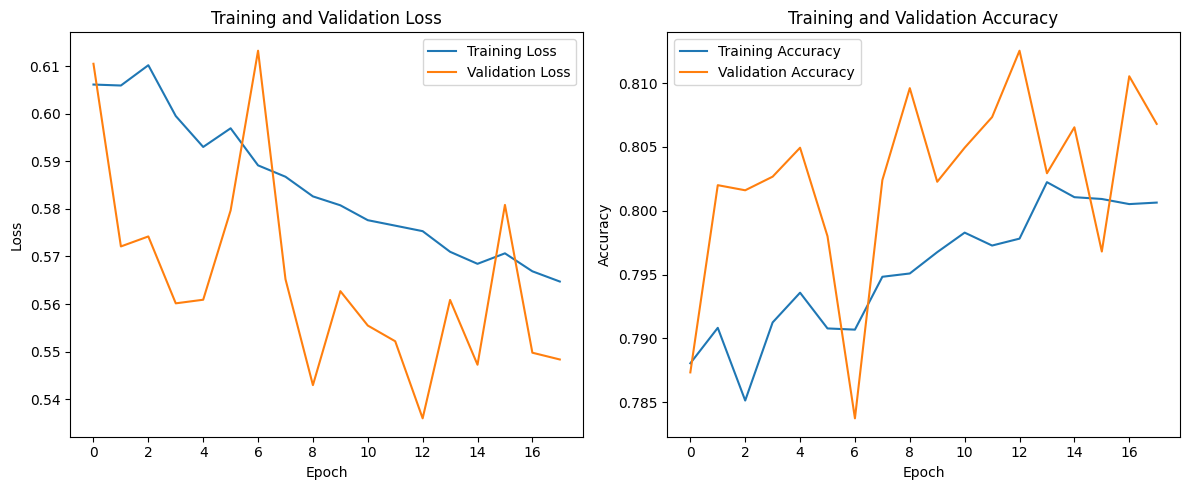

In [172]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(history):
    '''
    Function to plot training and validation loss and accuracy.
    Accepts a dictionary containing lists of loss and accuracy values.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting training and validation loss
    axs[0].plot(history['train_loss'], label='Training Loss')
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting training and validation accuracy
    axs[1].plot(history['train_accuracy'], label='Training Accuracy')
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()
    return fig  # Return the figure object for saving or further manipulation

# Plot using the modified function
fig = plot_losses(history_cnn)

# fig.savefig('training_metrics.png')

In [9]:
model_cnn.save('../model/cnn_tf213.keras')
model_cnn.save('model/cnn_tf213.keras')

CNN with PCA

In [12]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

n_components = pca.n_components_

model_cnn_pca = Sequential([
    Input(shape=(n_components,)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax'),
])

# print(model_cnn.summary())

model_cnn_pca.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),     
    optimizer = optimizers.Adam(learning_rate=3e-4),                               
    metrics =["accuracy"],                                                       
)

history_cnn_pca = model_cnn_pca.fit(X_train_pca, y_train.flatten(), 
                            batch_size = 64, 
                            epochs = 20,
                            verbose = 2,
                            validation_data=(X_validate_pca, y_validate.flatten()))

Epoch 1/20
665/665 - 4s - loss: 2.3287 - accuracy: 0.1475 - val_loss: 2.1265 - val_accuracy: 0.2667 - 4s/epoch - 6ms/step
Epoch 2/20
665/665 - 2s - loss: 2.1216 - accuracy: 0.2165 - val_loss: 1.9643 - val_accuracy: 0.3220 - 2s/epoch - 4ms/step
Epoch 3/20
665/665 - 2s - loss: 2.0121 - accuracy: 0.2636 - val_loss: 1.8524 - val_accuracy: 0.3527 - 2s/epoch - 3ms/step
Epoch 4/20
665/665 - 2s - loss: 1.9289 - accuracy: 0.2999 - val_loss: 1.7827 - val_accuracy: 0.3773 - 2s/epoch - 4ms/step
Epoch 5/20
665/665 - 2s - loss: 1.8741 - accuracy: 0.3239 - val_loss: 1.7288 - val_accuracy: 0.3957 - 2s/epoch - 3ms/step
Epoch 6/20
665/665 - 2s - loss: 1.8257 - accuracy: 0.3436 - val_loss: 1.6957 - val_accuracy: 0.4127 - 2s/epoch - 4ms/step
Epoch 7/20
665/665 - 2s - loss: 1.7922 - accuracy: 0.3578 - val_loss: 1.6662 - val_accuracy: 0.4201 - 2s/epoch - 4ms/step
Epoch 8/20
665/665 - 2s - loss: 1.7571 - accuracy: 0.3761 - val_loss: 1.6361 - val_accuracy: 0.4305 - 2s/epoch - 3ms/step
Epoch 9/20
665/665 - 3s 

In [14]:
model_cnn_pca.save('../model/cnn_pca_tf213.keras')
model_cnn_pca.save('model/cnn_pca_tf213.keras')

### Evaluate accuracy & prediction time

Load the model

In [17]:
from tensorflow.keras.models import load_model

cnn_model_path = 'model/cnn_tf213.keras'
model_cnn = load_model(cnn_model_path)

In [18]:
# evaluate accuracy
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(test_accuracy, 3)}")

# evaluate training time
evaluate_prediction_time(model_cnn, X_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.8539 - accuracy: 0.7053
Test Accuracy: 0.705
4/4 [==============================] - 0s 6ms/step
Total time to predict 100 samples: 0.16 seconds


CNNs are superior for image classification due to their ability to learn high-level features directly from data, adapt to complex patterns, and perform efficiently in real-time applications, including on IoT devices. While PCA + SVM might still be used for less complex or highly specific tasks where training data is limited or when computational simplicity is prioritized, CNNs are the standard for most current image processing tasks. This difference is crucial in educational settings, emphasizing the need to train students on technologies that they are most likely to use in industry, particularly in cutting-edge fields like machine learning and computer vision.

### Hyperparameter tuning

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential([
        Input(shape=(32, 32, 3)),
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
               padding=hp.Choice('conv_1_padding', values=['same', 'valid']),
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.05)),

        Conv2D(filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
               kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
               padding=hp.Choice('conv_2_padding', values=['same', 'valid']),
               activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.05)),

        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_3', min_value=0.3, max_value=0.5, step=0.05)),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  # Increased number of trials for finer exploration
    executions_per_trial=1,
    directory='ml_result/hp_tuning',
    project_name='hparam_tuning'
)

tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_validate, y_validate))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best model uses {best_hps.get('conv_1_filter')} filters in the first Conv layer,
a kernel size of {best_hps.get('conv_1_kernel')}, and {best_hps.get('dense_units')} units in the dense layer,
with a learning rate of {best_hps.get('learning_rate')}.
""")

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
# loss, accuracy = best_model.evaluate(X_test, y_test)
# print(f'Test accuracy: {accuracy}, Test loss: {loss}')


Trial 30 Complete [00h 05m 13s]
val_accuracy: 0.6797333359718323

Best val_accuracy So Far: 0.7330666780471802
Total elapsed time: 07h 32m 57s

The best model uses 64 filters in the first Conv layer,
a kernel size of 3, and 128 units in the dense layer,
with a learning rate of 0.001.



In [22]:
for hparam in best_hps.space:
    print(f"{hparam.name}: {best_hps.get(hparam.name)}")

conv_1_filter: 64
conv_1_kernel: 3
conv_2_filter: 128
conv_2_kernel: 3
dense_units: 128
learning_rate: 0.001
conv_1_padding: same
dropout_1: 0.15000000000000002
conv_2_padding: valid
dropout_2: 0.25
dropout_3: 0.3


Epoch 1/20
665/665 - 56s - loss: 0.6838 - accuracy: 0.7561 - val_loss: 0.7694 - val_accuracy: 0.7340 - 56s/epoch - 84ms/step
Epoch 2/20
665/665 - 55s - loss: 0.6743 - accuracy: 0.7596 - val_loss: 0.7660 - val_accuracy: 0.7355 - 55s/epoch - 83ms/step
Epoch 3/20
665/665 - 55s - loss: 0.6505 - accuracy: 0.7673 - val_loss: 0.7614 - val_accuracy: 0.7389 - 55s/epoch - 83ms/step
Epoch 4/20
665/665 - 58s - loss: 0.6347 - accuracy: 0.7730 - val_loss: 0.7773 - val_accuracy: 0.7335 - 58s/epoch - 87ms/step
Epoch 5/20
665/665 - 58s - loss: 0.6160 - accuracy: 0.7779 - val_loss: 0.7608 - val_accuracy: 0.7392 - 58s/epoch - 88ms/step
Epoch 6/20
665/665 - 55s - loss: 0.6013 - accuracy: 0.7841 - val_loss: 0.7682 - val_accuracy: 0.7384 - 55s/epoch - 83ms/step
Epoch 7/20
665/665 - 57s - loss: 0.5919 - accuracy: 0.7854 - val_loss: 0.7645 - val_accuracy: 0.7371 - 57s/epoch - 85ms/step
Epoch 8/20
665/665 - 57s - loss: 0.5743 - accuracy: 0.7924 - val_loss: 0.7932 - val_accuracy: 0.7381 - 57s/epoch - 86ms/step


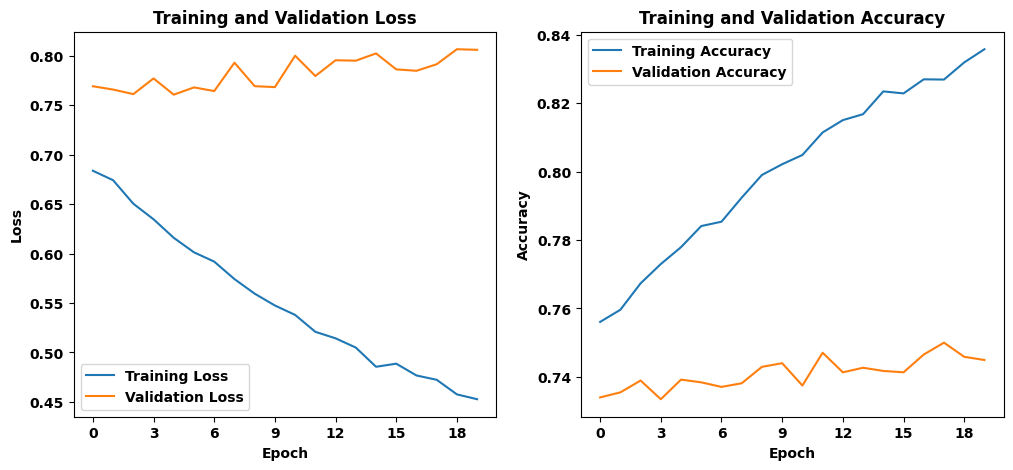

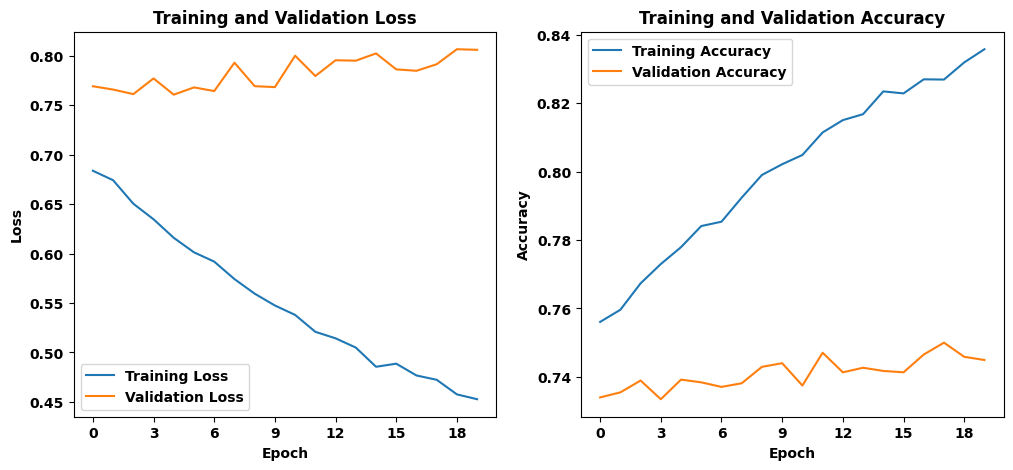

In [11]:
history_best_model = best_model.fit(
    X_train, y_train,
    epochs=20,  # You can adjust the number of epochs based on your requirement
    batch_size=64,
    verbose=2,
    validation_data=(X_validate, y_validate)
)

plot_losses(history_best_model)

In [15]:
best_model.save('../model/cnn_tuned_tf213.keras')
best_model.save('model/cnn_tuned_tf213.keras')

In [14]:
# evaluate accuracy
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {round(test_accuracy, 3)}")

# evaluate training time
evaluate_prediction_time(best_model, X_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.8266 - accuracy: 0.7360
Test Accuracy: 0.736
4/4 [==============================] - 0s 10ms/step
Total time to predict 100 samples: 0.25 seconds
